In [1]:
window_size = 250
step_size = 50

In [2]:
import numpy as np 
import bottleneck as bn
import matplotlib.pyplot as plt
import ruptures as rpt
import json


class Signal():
    def __init__(self, path_to_file=None, signal=None, step=10, window_size = 50):
        """
        Args:
        path_to_file (str): path to file containing numpy array for the signal
        signal (np.array): numpy array containing the signal
        Both arguments are optional. 
        This class can be instantiated to just use the functions.
        """
        if path_to_file:
            self.signal = np.load(path_to_file)
            
        else:
            if len(np.array(signal).shape) == 1:
                self.signal = np.expand_dims(np.array(signal), axis =1)
            else: 
                self.signal = np.array(signal)

        self.n_samples = self.signal.shape[0]
        self.step = step
        self.window_size = window_size
        if self.n_samples < 50:
            raise Exception ("signal too short! minimum size = 50 samples")
    
        self.features = {"mav":self.mav, "rms":self.rms, "ssc":self.ssc, "wl":self.wl, "var":self.var, 
                         "iasd":self.iasd, "iatd":self.iatd}
        self.n_features = self.signal.shape[1]*len(self.features)
        
    def get_features(self, list_features = "all", remove_transition=False):
        if remove_transition:
            self.remove_transition()
        features = np.empty((0, self.n_features))
        for idx in range(0, self.n_samples-self.window_size, self.step):
            x = self.signal[idx:idx+self.window_size, :]
            features = np.concatenate((features, self.get_features_window(x, list_features)))
        return features
    
    def get_features_window(self, x, list_features="all"):
        features = np.empty((1, 0))
        for f in self.features.values():
            features = np.concatenate((features, f(x).reshape(1, x.shape[1])), axis=1)
        return features

    def remove_transition(self):
        s = self.get_features(list_features=["mav"]).sum(axis=1)
        # detection
        algo = rpt.Binseg(model="l2").fit(s)
        result = algo.predict(n_bkps=1)[0]
        if result > len(s)//2:
            result = 20
        trans_idx = result*self.step
        if self.signal.shape[0]>2*trans_idx:
            self.signal = self.signal[trans_idx:, :]
            self.n_samples = self.signal.shape[0]

    # ops 
    def mav(self, x):                                      # mean absolute value
        return sum(abs(x)) / x.shape[0]

    def rms(self, x):                                      # root mean square
        return ((sum(x ** 2)) / x.shape[0]) ** (1 / 2)

    def wl (self, x):                                      # waveform length
        return sum(abs(x[:-1] - x[1:]))

    def ssc(self, x, delta = 1):                           # slope of sign change
        f = lambda x: (x >= delta).astype(float)
        return sum(f(-(x[1:-1, :] - x[:-2, :])*(x[1:-1] - x[2:])))
    
    def var(self, x):                                      # variance
        return sum((x ** 2)) / (x.shape[0] - 1)
    
    def derivative(self, x):
        return x[1:] - x[:-1]
    
    def iasd(self, x):                                     # integrated absolute of second derivative
        return (sum(abs(self.derivative(self.derivative(x)))))
    
    def iatd(self, x):                                     # integrated absolute of third derivative
        return (sum(abs(self.derivative(self.derivative(self.derivative(x))))))
    
    def sliding_avg(self, x, w=1):                         # sliding average with window size w
        return np.convolve(x, np.ones(w), 'valid') / w
    
    def sliding_var(self, x, w=1):
        return bn.move_var(x, window=w)
    
    #vis    
    def display(self, attr = "energy", w = 5):
        plt.figure()
        """
        w (window size) only applicable for functions of energy
        """
        if attr == "energy":
            energy = self.get_features(list_features=["mav"])
            energy = energy.sum(axis = 1)
            plt.plot(energy)
            plt.xlabel("time (samples)")
            plt.ylabel("Energy")
        if attr == "avg_slope_energy":
            energy = self.get_features(list_features=["mav"])
            energy = energy.sum(axis = 1)
            slope = energy[1:] - energy[:-1]
            avg_slope = self.sliding_avg(slope, w)
            plt.plot(avg_slope)
            plt.xlabel("time (samples)")
            plt.ylabel(f"Avg. slope (window = {w})")
        if attr == "sliding_var_energy":
            energy = self.get_features(list_features=["mav"])
            energy = energy.sum(axis = 1)
            mov_var = bn.move_var(energy, window=w)
            mov_avg = bn.move_mean(energy, window=w)
            plt.plot(mov_var/mov_avg)
            plt.xlabel("time (samples)")
            plt.ylabel(f"Moving Variance of Energy (window = {w})")
        ylim_bottom = min(0, plt.gca().get_ylim()[0])
        plt.gca().set_ylim(bottom=ylim_bottom)




In [3]:
import matplotlib.pyplot as plt 


In [4]:
def parse_ossur_sensor_recording(fpath):
    with open(fpath) as f:
        data = json.load(f)
    emg_shape = min(len(data['1264']['value1']), len(data['1265']['value1'])), 4
    emg = np.zeros(emg_shape)
    emg[:,0] = data['1264']['value1'][:emg_shape[0]]
    emg[:,1] = data['1264']['value2'][:emg_shape[0]]
    emg[:,2] = data['1265']['value1'][:emg_shape[0]]
    emg[:,3] = data['1265']['value2'][:emg_shape[0]]

    disp_shape = min(len(data['528']['value1']), len(data['529']['value1'])), 4
    disp = np.zeros(disp_shape)
    disp[:,0] = data['528']['value1'][:disp_shape[0]]
    disp[:,1] = data['528']['value2'][:disp_shape[0]]
    disp[:,2] = data['529']['value1'][:disp_shape[0]]
    disp[:,3] = data['529']['value2'][:disp_shape[0]]

    return emg, disp
import numpy as np

def resample(signal, n):
    # Initialize the array to hold the resampled signal
    resampled_signal_2d = np.zeros((n, signal.shape[1]))
    
    # New sample points for resampling
    new_positions = np.linspace(0, 1, n, endpoint=False)
    
    # Original positions corresponding to the existing samples
    original_positions = np.linspace(0, 1, signal.shape[0], endpoint=False)
    
    # Apply resampling for each row
    for i in range(signal.shape[1]):
        resampled_signal_2d[:, i] = np.interp(new_positions, original_positions, signal[:,i])
    
    return resampled_signal_2d


In [5]:
from tqdm import tqdm 
from glob import glob 
from pathlib import PureWindowsPath
import pandas as pd

data_dir = "C:/Users/rajsu/Documents/iLimb/DataCollection/OssurSensor/data"
subject = "David1"
protocol = "ossur"
files = glob(f"{data_dir}/{subject}*/*.npy")
df = None
for fpath in tqdm(files):
    win_fpath = PureWindowsPath(fpath)
    sub = win_fpath.parts[-2][:-1]
    take = win_fpath.parts[-2][-1]
    
    gesture = win_fpath.stem[:-20]
    timestamp = win_fpath.stem[-19:]
    
    emg, disp = parse_ossur_sensor_recording(fpath)
    emg = Signal(signal = emg, window_size=window_size, step=step_size)

    emg_features = emg.get_features()
    disp_features = resample(disp, emg_features.shape[0])
    features = np.concatenate([emg_features, disp_features], axis=1)

    if df is None:
        columns = []
        for feat in emg.features.keys():
            columns.extend([f"{feat}_{idx}" for idx in range(4)])
        
        columns.extend(["disp1","disp2", "disp3", "disp4", "gesture", "subject", "take"])
        df=pd.DataFrame(columns=columns)
    
    temp_df = pd.DataFrame(features, columns = columns[:-3])
    temp_df["gesture"] = [gesture]*temp_df.shape[0]

    
    temp_df["timestamp"] = [timestamp]*temp_df.shape[0]

    temp_df["subject"] = [sub]*temp_df.shape[0]
    temp_df["take"] = [take]*temp_df.shape[0]

    df = pd.concat([df, temp_df], ignore_index=True)


100%|██████████| 60/60 [00:04<00:00, 14.97it/s]


In [6]:
import json 
gesture = "wrist_supin"
print(subject)
def df_idx_to_emg_window(df_idx):
    return (df_idx*step_size, df_idx*step_size + step_size)

def visualise_recordings(subject, gesture, errors = None):
    files = glob(f"{data_dir}/{subject}*/{gesture}*.npy")
    fpath = files[0]
    with open(fpath) as f:
        data = json.load(f)
    plt.figure(figsize = (10, len(files)))
    for idx, fpath in enumerate(files):
        with open(fpath) as f:
            data = json.load(f)
        emg, disp = parse_ossur_sensor_recording(fpath)
        flex = np.mean(emg[:, :2], axis=1)
        ext = np.mean(emg[:, 2:], axis=1)
        disp_flex = disp[:, 3]
        disp_ext = disp[:, 1]

        if errors:
            error_idxs = []
            for i in errors[idx]:
                error_idxs.extend(list(range(*df_idx_to_emg_window(i))))
            error_flex = [f if i in error_idxs else np.nan for i, f in enumerate(flex)]
            error_ext = [e if i in error_idxs else np.nan for i, e in enumerate(ext)]


        plt.subplot(len(files), 4, idx*4+1)
        plt.plot(flex)
        if errors:
            plt.plot(error_flex, c='r')
        plt.xticks([])
        plt.ylim(-2000, 2000)
        if idx == 0:
            plt.title("extensor emg")
        plt.subplot(len(files), 4, idx*4+2)
        plt.plot(ext)
        if errors:
            plt.plot(error_ext, c='r')
        plt.yticks([])
        plt.xticks([])
        plt.ylim(-2000, 2000)
        if idx == 0:
            plt.title("flexor emg")
        plt.subplot(len(files), 4, idx*4+3)
        plt.plot(disp_flex, c="orange")
        plt.yticks([])

        plt.xticks([])
        plt.ylim(-2000, 2000)
        if idx == 0:
            plt.title("extensor disp")
        plt.subplot(len(files), 4, idx*4+4)
        plt.plot(disp_ext, c="orange")
        plt.yticks([])
        plt.xticks([])
        plt.ylim(-2000, 2000)
        if idx == 0:
            plt.title("flexor disp")
    plt.suptitle(gesture)
    plt.tight_layout()


David1


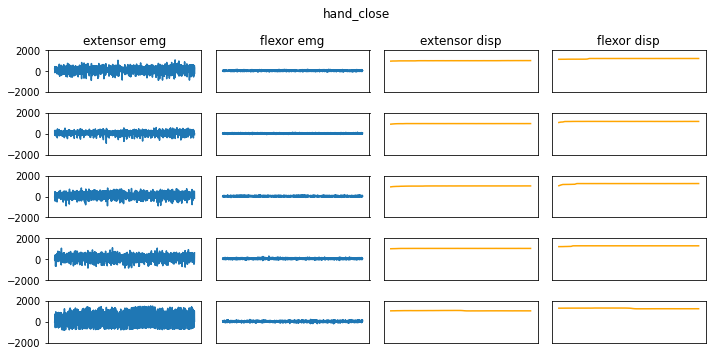

In [7]:
visualise_recordings("Raj3", "hand_close")

In [8]:
df.head()

,mav_0,mav_1,mav_2,mav_3,rms_0,rms_1,rms_2,rms_3,ssc_0,ssc_1,...,iatd_2,iatd_3,disp1,disp2,disp3,disp4,gesture,subject,take,timestamp
0,81.412,84.376,232.952,243.744,108.958873,84.895983,319.482281,247.084342,123.0,1.0,...,115049.0,429.0,0.0,838.000000,367.000000,1531.000000,hand_close,David,1,2024-03-05T16-39-22
1,86.952,82.312,194.412,230.288,112.460553,82.879817,255.982085,235.043877,124.0,14.0,...,94672.0,433.0,0.0,838.000000,367.923077,1531.923077,hand_close,David,1,2024-03-05T16-39-22
2,85.368,85.884,197.604,204.272,112.491529,86.993954,263.009331,206.388372,116.0,19.0,...,98655.0,410.0,0.0,838.153846,366.846154,1530.846154,hand_close,David,1,2024-03-05T16-39-22
3,82.464,84.648,174.536,191.532,109.492685,85.892444,227.929638,193.012880,119.0,22.0,...,95476.0,399.0,0.0,838.769231,366.000000,1530.000000,hand_close,David,1,2024-03-05T16-39-22
4,86.596,82.408,181.888,180.424,114.896388,83.752827,238.038014,180.752184,114.0,22.0,...,100788.0,390.0,0.0,838.000000,365.692308,1529.692308,hand_close,David,1,2024-03-05T16-39-22


In [9]:
from data import GestureRecognitionDataset
ds= GestureRecognitionDataset(data_dir)
df = ds.timestamp_to_iter(df)

In [10]:
from model import GestureRecognitionModel
from imblearn.under_sampling import RandomUnderSampler
from sklearn.metrics import confusion_matrix
import seaborn as sns




In [11]:
gestures_to_use = ["hand_close", "hand_neutral", "hand_open", 
                    "wrist_supin", "wrist_pron","thumb_abd", "thumb_add", "pinch", "lateral", "point"] 

accuracies = []
preds = []
ys=[]
df = df[df.gesture.isin(gestures_to_use)]
gestures = df.gesture.unique()
gesture_to_int = {gesture:i for i, gesture in enumerate(gestures)}
int_to_gesture = {val:key for key, val in gesture_to_int.items()}

def get_gesturewise_errors(y, preds):
    y, preds = np.array(y), np.array(preds)
    errors = {}
    for i in list(set(y)):
        gesture = int_to_gesture[i]
        gesture_idxs = np.where(np.array(y) == i)[0]
        gesture_ys = y[gesture_idxs]
        gesture_preds = preds[gesture_idxs]
        error_idxs = np.where(gesture_ys!=gesture_preds)
        errors[gesture] = error_idxs
    return errors




In [12]:

errors = {}
if protocol == "ossur":
    for i in range(1,6):
        df_train = df[df["iteration"] != i]
        df_test = df[df["iteration"] == i]
        model = GestureRecognitionModel()
        features_to_keep = df_train.columns[:-4]
        X_train, y_train = df_train[features_to_keep], [gesture_to_int[gesture] for gesture in df_train.gesture]
        X_test, y_test = df_test[features_to_keep], [gesture_to_int[gesture] for gesture in df_test.gesture]
        rus = RandomUnderSampler()
        X_test, y_test = rus.fit_resample(X_test, y_test)
        model.train(X_train, y_train)
        accuracies.append(model.evaluate(X_test, y_test))
        pred = model.predict(X_test)
        preds.extend(pred)
        ys.extend(y_test)
        errors[i] = get_gesturewise_errors(y_test, pred)


if protocol == "eodyne":
    for i in range(1,4):
        df_train = df[df["take"] != str(i)]
        df_test = df[df["take"] == str(i)]
        model = GestureRecognitionModel()
        features_to_keep = df_train.columns[:-4]
        X_train, y_train = df_train[features_to_keep], [gesture_to_int[gesture] for gesture in df_train.gesture]
        X_test, y_test = df_test[features_to_keep], [gesture_to_int[gesture] for gesture in df_test.gesture]
        rus = RandomUnderSampler()
        X_test, y_test = rus.fit_resample(X_test, y_test)
        model.train(X_train, y_train)
        accuracies.append(model.evaluate(X_test, y_test))
        preds.extend(model.predict(X_test))
        ys.extend(y_test)

print(f"Final Accuracy: {np.mean(accuracies)}")

Final Accuracy: 0.9412307692307692


In [14]:
#filter to files with over 3 errors
for i in errors.keys():
    errors[i] = {key:value for key, value in errors[i].items() if len(value[0])>3}
errors

{1: {'hand_neutral': (array([ 3,  4,  5,  6, 12, 13, 16, 19, 21, 23, 24, 25, 26, 28, 30, 31, 32,
          34, 35, 39, 40, 43, 44, 53, 54, 61, 62, 64], dtype=int64),),
  'point': (array([ 1,  3,  7, 10, 11, 12, 13, 14, 16, 18, 20, 21, 23, 24, 26, 29, 31,
          32, 37, 38, 45, 46, 48, 49, 50, 51, 53, 54, 57, 60, 63],
         dtype=int64),),
  'thumb_abd': (array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
          17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
          34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
          51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64],
         dtype=int64),)},
 2: {'lateral': (array([ 0,  3,  4,  5,  6,  7,  8,  9, 10, 16, 17, 18, 19, 20, 21, 22, 23,
          25, 26, 27, 28, 29, 30, 31, 34, 35, 37, 38, 39, 40, 41, 42, 43, 44,
          45, 46, 47, 49, 50, 52, 53, 55, 56, 57, 59, 60, 62, 63],
         dtype=int64),),
  'wrist_supin': (array([12, 15, 19, 31, 38, 40, 41

In [24]:
a = {1:2, 2:4, 3:5}
for i, (j, k) in enumerate(a.items()):
    print(i, j, k)

0 1 2
1 2 4
2 3 5


In [56]:
import os

def get_recording(subject, gesture, iteration):
    files = glob(f"{data_dir}/{subject}*/{gesture}*.npy")
    files.sort(key=os.path.getmtime)
    return files[iteration-1]

    
def visualise_errors(subject, error_dict):
    # reshape the error dict to {fpath: list of errors}
    file_errors = {}
    for iteration, errors in error_dict.items():
        for gesture in errors.keys():
            fpath = get_recording(subject, gesture, iteration)
            file_errors[fpath] = (errors[gesture][0], gesture)
    plt.figure(figsize = (10, len(file_errors)))
    for idx, (fpath, errors) in enumerate(file_errors.items()):
        emg, disp = parse_ossur_sensor_recording(fpath)
        flex = np.mean(emg[:, :2], axis=1)
        ext = np.mean(emg[:, 2:], axis=1)
        disp_flex = disp[:, 3]
        disp_ext = disp[:, 1]
        error_idxs = []
        for i in errors[0]:
            error_idxs.extend(list(range(*df_idx_to_emg_window(i))))
        error_flex = [f if i in error_idxs else np.nan for i, f in  enumerate(flex)]
        error_ext = [e if i in error_idxs else np.nan for i, e in enumerate(ext)]
        plt.subplot(len(file_errors), 5, idx*5+1)
        plt.plot(flex)
        if errors:
            plt.plot(error_flex, c='r')
        plt.xticks([])
        plt.ylim(-2000, 2000)
        if idx == 0:
            plt.title("extensor emg")
        plt.subplot(len(file_errors), 5, idx*5+2)
        plt.plot(ext)
        if errors:
            plt.plot(error_ext, c='r')
        plt.yticks([])
        plt.xticks([])
        plt.ylim(-2000, 2000)
        if idx == 0:
            plt.title("flexor emg")
        plt.subplot(len(file_errors), 5, idx*5+3)
        plt.plot(disp_flex, c="orange")
        plt.yticks([])

        plt.xticks([])
        plt.ylim(-2000, 2000)
        if idx == 0:
            plt.title("extensor disp")
        plt.subplot(len(file_errors), 5, idx*5+4)
        plt.plot(disp_ext, c="orange")
        plt.yticks([])
        plt.xticks([])
        plt.ylim(-2000, 2000)
        if idx == 0:
            plt.title("flexor disp")
        ax = plt.subplot(len(file_errors), 5, idx*5+5)
        plt.text(0.5, 0.5, errors[1],  horizontalalignment='center',
        verticalalignment='center', transform=ax.transAxes, fontdict={"fontsize":13})
        plt.axis("off")
    plt.suptitle(subject)
    plt.tight_layout()


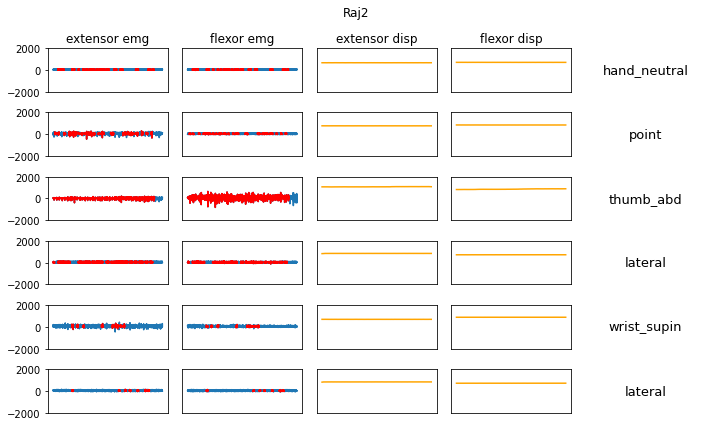

In [57]:
visualise_errors('Raj2', errors)

In [67]:
a = {1:(1, 2, 3), 2:(4, 5, 6), 3: (3, 2, 1)}
for i,j in enumerate(sorted(a.items(), key=lambda i:i[1][2])):
    print(i, j)

0 (3, (3, 2, 1))
1 (1, (1, 2, 3))
2 (2, (4, 5, 6))


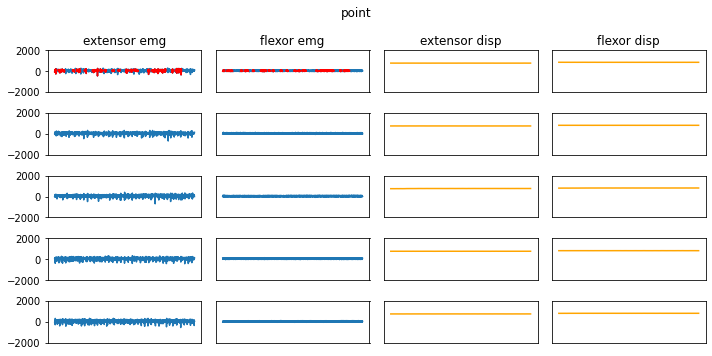

In [87]:
errors_hand_close = {i-1: errors[i]['point'][0] for i in errors.keys()}
visualise_recordings("Raj2", "point", errors = errors_hand_close)

In [49]:

a

[1, 2, 3, 4, 5]

In [223]:
accuracies

[0.7153846153846154,
 0.8338461538461538,
 0.7876923076923077,
 0.8584615384615385,
 0.6384615384615384]

Text(0.5, 1.0, 'Raj3: 95.91%')

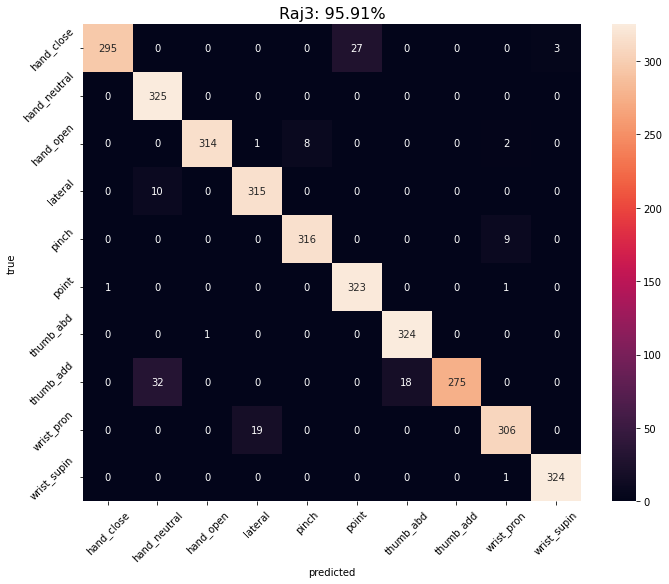

In [60]:
cf_matrix = confusion_matrix(ys, preds)
fig = plt.figure(figsize = (10, 8))
sns.heatmap(cf_matrix, annot=True, fmt=".0f")
plt.yticks(np.arange(0.5,len(int_to_gesture), 1), [int_to_gesture[i] for i in range(len(int_to_gesture))], rotation=45)
plt.xticks(np.arange(0.5,len(int_to_gesture), 1), [int_to_gesture[i] for i in range(len(int_to_gesture))], rotation=45)
plt.ylabel("true")
plt.xlabel("predicted")
plt.tight_layout()
plt.title(f"{subject}: {np.mean(accuracies)*100:.2f}%", fontdict={'fontsize': 16, 'fontweight': 'medium'})

In [225]:

gestures_to_use = ["hand_close", "hand_neutral", "hand_open", 
                    "wrist_supin", "wrist_pron","thumb_abd", "thumb_add"] 


accuracies = []
preds = []
ys=[]
df = df[df.gesture.isin(gestures_to_use)]
gestures = df.gesture.unique()
gesture_to_int = {gesture:i for i, gesture in enumerate(gestures)}
int_to_gesture = {val:key for key, val in gesture_to_int.items()}
if protocol == "ossur":
    for i in range(1,6):
        df_train = df[df["iteration"] != i]
        df_test = df[df["iteration"] == i]
        model = GestureRecognitionModel()
        features_to_keep = df_train.columns[:-4]
        X_train, y_train = df_train[features_to_keep], [gesture_to_int[gesture] for gesture in df_train.gesture]
        X_test, y_test = df_test[features_to_keep], [gesture_to_int[gesture] for gesture in df_test.gesture]
        rus = RandomUnderSampler()
        X_test, y_test = rus.fit_resample(X_test, y_test)
        model.train(X_train, y_train)
        accuracies.append(model.evaluate(X_test, y_test))
        preds.extend(model.predict(X_test))
        ys.extend(y_test)


if protocol == "eodyne":
    for i in range(1,4):
        df_train = df[df["take"] != str(i)]
        df_test = df[df["take"] == str(i)]
        model = GestureRecognitionModel()
        features_to_keep = df_train.columns[:-4]
        X_train, y_train = df_train[features_to_keep], [gesture_to_int[gesture] for gesture in df_train.gesture]
        X_test, y_test = df_test[features_to_keep], [gesture_to_int[gesture] for gesture in df_test.gesture]
        rus = RandomUnderSampler()
        X_test, y_test = rus.fit_resample(X_test, y_test)
        model.train(X_train, y_train)
        accuracies.append(model.evaluate(X_test, y_test))
        preds.extend(model.predict(X_test))
        ys.extend(y_test)


Text(0.5, 1.0, 'Sergio: 79.21%')

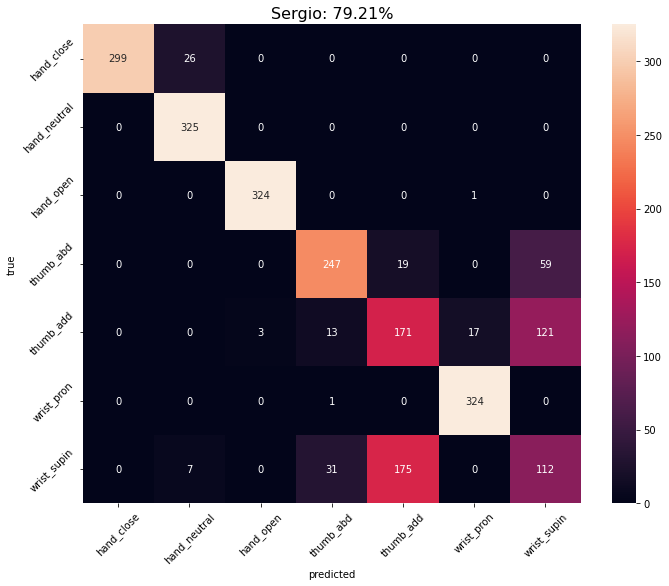

In [226]:
cf_matrix = confusion_matrix(ys, preds)
fig = plt.figure(figsize = (10, 8))
sns.heatmap(cf_matrix, annot=True, fmt=".0f")
plt.yticks(np.arange(0.5,len(int_to_gesture), 1), [int_to_gesture[i] for i in range(len(int_to_gesture))], rotation=45)
plt.xticks(np.arange(0.5,len(int_to_gesture), 1), [int_to_gesture[i] for i in range(len(int_to_gesture))], rotation=45)
plt.ylabel("true")
plt.xlabel("predicted")
plt.tight_layout()
plt.title(f"{subject}: {np.mean(accuracies)*100:.2f}%", fontdict={'fontsize': 16, 'fontweight': 'medium'})
